# **Melanoma Detection Assignment**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Reading the data

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


In [2]:
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Since we are using the data by mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Defining the path for train and test images
train_dataset = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train")
test_dataset = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melenoma/Test")

In [5]:
image_count_train = len(list(train_dataset.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_dataset.glob('*/*.jpg')))
print(image_count_test)

2249
118



Create a Dataset

In [6]:
#Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)



Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [8]:
from matplotlib import test

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    subset='validation',
    validation_split=0.2
)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
# Listing out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Found 2249 files belonging to 9 classes.


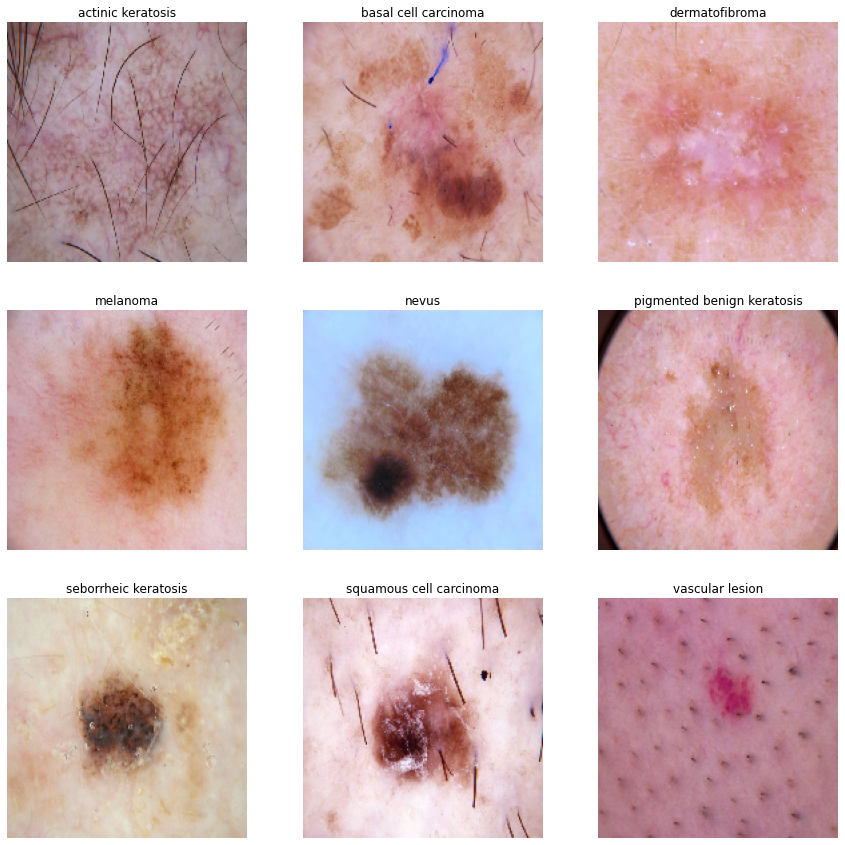

In [10]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dataset,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for cl_name in class_names:
    files_path_dict[cl_name] = list(map(lambda x:str(train_dataset)+'/'+cl_name+'/'+x,os.listdir(str(train_dataset)+'/'+cl_name)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for cl_name in class_names:
    path_list = files_path_dict[cl_name][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(cl_name)
    plt.axis("off")

 Visualize distribution of classes in the training dataset.

In [11]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_dir = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_dir,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(train_dataset)
df

,Class,No. of Image
0,seborrheic keratosis,77
1,dermatofibroma,105
2,pigmented benign keratosis,462
3,nevus,357
4,melanoma,438
5,squamous cell carcinoma,181
6,vascular lesion,139
7,basal cell carcinoma,376
8,actinic keratosis,114


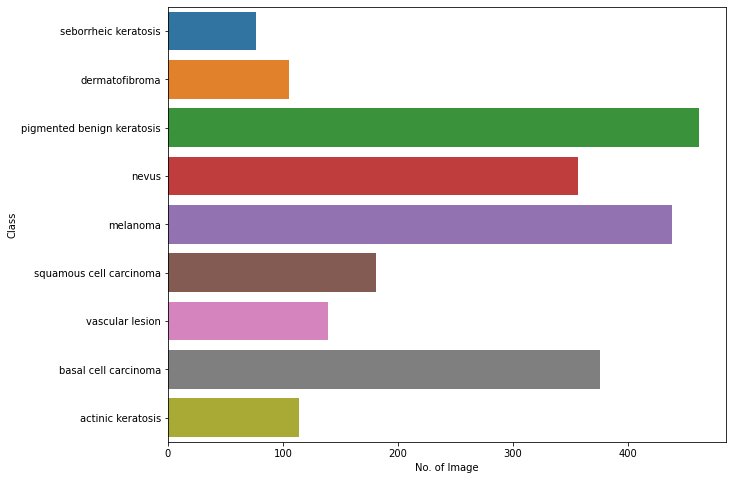

In [12]:
#Visualize the data in barplot

plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### **Creating a model**

## Model 1

In [13]:
# #`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

# #`Dataset.prefetch()` overlaps data preprocessing and model execution while training.



In [14]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer
model.add(layers.Conv2D(16,kernel_size=(5,5),activation='relu'))
model.add(layers.Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(5,5),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(len(class_names),activation='softmax'))


Compile the model

In [15]:
#Compile the Model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 176, 176, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 32)      12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 82, 82, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                    

Train the model

In [20]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
57/57 [==============================] - 25s 413ms/step - loss: 0.6616 - accuracy: 0.7833 - val_loss: 2.4411 - val_accuracy: 0.4566
Epoch 2/20
57/57 [==============================] - 16s 249ms/step - loss: 0.4712 - accuracy: 0.8283 - val_loss: 2.7754 - val_accuracy: 0.4343
Epoch 3/20
57/57 [==============================] - 16s 247ms/step - loss: 0.3723 - accuracy: 0.8683 - val_loss: 2.5391 - val_accuracy: 0.4588
Epoch 4/20
57/57 [==============================] - 17s 276ms/step - loss: 0.2897 - accuracy: 0.8900 - val_loss: 2.8402 - val_accuracy: 0.4454
Epoch 5/20
57/57 [==============================] - 16s 248ms/step - loss: 0.2749 - accuracy: 0.8883 - val_loss: 3.2447 - val_accuracy: 0.4120
Epoch 6/20
57/57 [==============================] - 16s 252ms/step - loss: 0.2844 - accuracy: 0.8906 - val_loss: 3.5304 - val_accuracy: 0.3452
Epoch 7/20
57/57 [==============================] - 16s 252ms/step - loss: 0.2242 - accuracy: 0.9139 - val_loss: 2.8671 - val_accuracy: 0.4454

### Visualizing training results

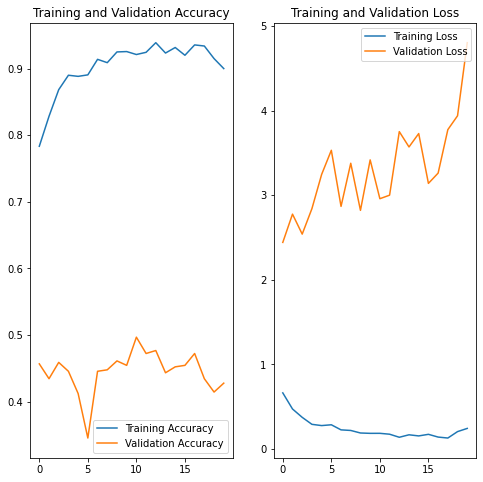

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding on the first base model**

This model is overfitting 

The accuracy is just around 77-90% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting

### Data Augmentation layer

In [22]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

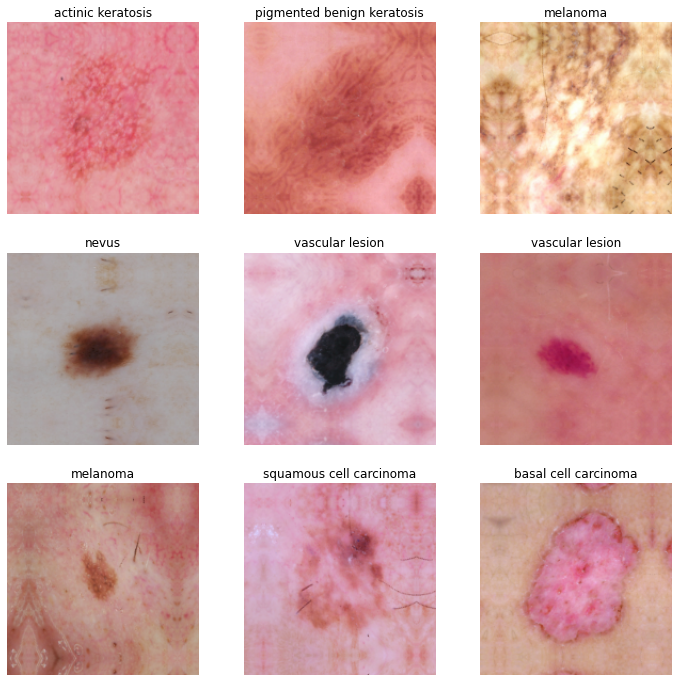

In [23]:
#visualizing how augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model 2

In [24]:
# This time we are using dropout layer
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



Compile the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Training the model

In [26]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
57/57 [==============================] - 20s 264ms/step - loss: 2.0680 - accuracy: 0.1817 - val_loss: 2.0690 - val_accuracy: 0.1960
Epoch 2/20
57/57 [==============================] - 17s 253ms/step - loss: 1.9705 - accuracy: 0.2617 - val_loss: 1.7432 - val_accuracy: 0.3742
Epoch 3/20
57/57 [==============================] - 16s 253ms/step - loss: 1.8277 - accuracy: 0.3172 - val_loss: 1.7217 - val_accuracy: 0.3653
Epoch 4/20
57/57 [==============================] - 16s 254ms/step - loss: 1.6273 - accuracy: 0.4172 - val_loss: 1.6961 - val_accuracy: 0.3786
Epoch 5/20
57/57 [==============================] - 16s 253ms/step - loss: 1.6036 - accuracy: 0.4400 - val_loss: 1.8126 - val_accuracy: 0.3675
Epoch 6/20
57/57 [==============================] - 16s 252ms/step - loss: 1.5456 - accuracy: 0.4583 - val_loss: 1.5744 - val_accuracy: 0.4588
Epoch 7/20
57/57 [==============================] - 16s 251ms/step - loss: 1.5001 - accuracy: 0.4778 - val_loss: 1.6486 - val_accuracy: 0.4254

Visualising the Data

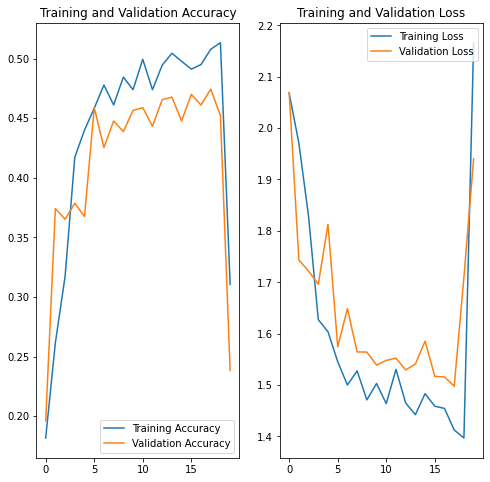

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding from Second Model**

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can concentrate on increasing the accuracy

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in train_dataset.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
df_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(df_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
...,...,...
2244,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2245,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2246,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2247,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion


In [29]:
df_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(df_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
...,...,...
2244,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2245,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2246,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2247,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion


<BarContainer object of 9 artists>

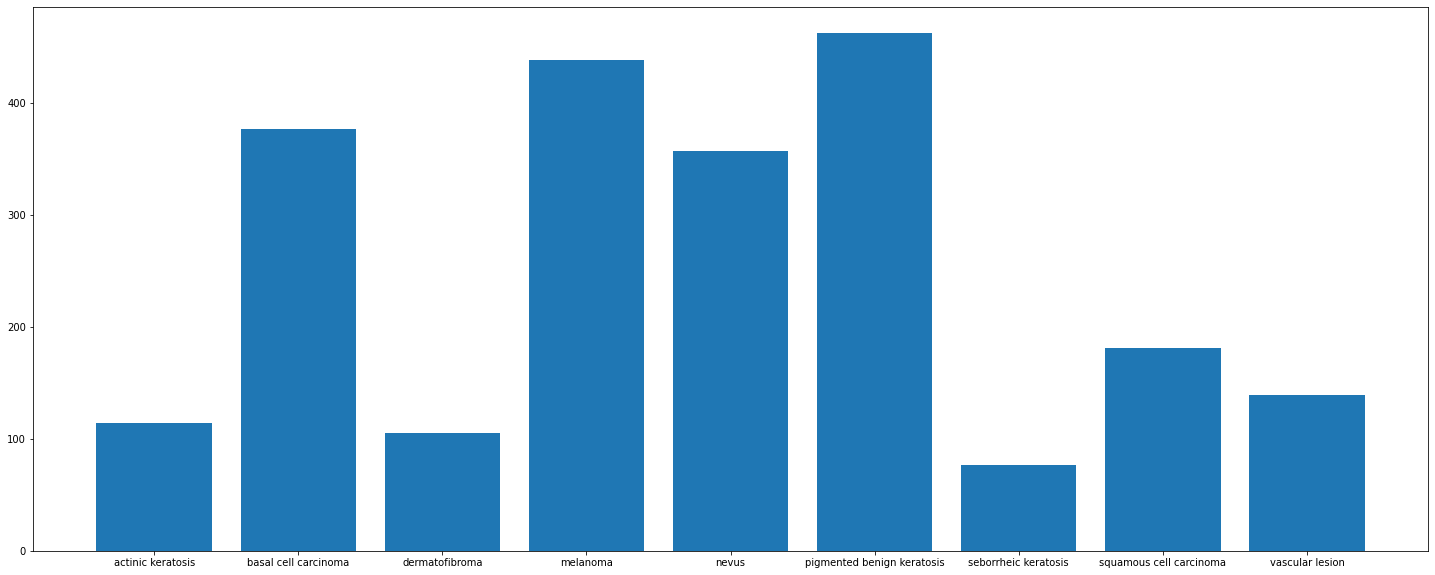

In [30]:
count=[]
for i in class_names:
    count.append(len(list(train_dataset.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

From the above details,it is clear that :



*   Seborrheic Keratosis has least number of samples
*   Actinic Keratosis and Dermatofibroma have proportionate number of classes. Basal cell Carcinoma and Nevus have proprtionate number of classes



In [31]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Augmentor Library layer code

In [32]:
pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import Augmentor

for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAB6B76B90>: 100%|██████████| 500/500 [00:52<00:00,  9.48 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBADC076250>: 100%|██████████| 500/500 [00:46<00:00, 10.80 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAB7649E10>: 100%|██████████| 500/500 [00:43<00:00, 11.42 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FBAB73FBA50>: 100%|██████████| 500/500 [00:46<00:00, 10.73 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBADC0F8990>: 100%|██████████| 500/500 [00:40<00:00, 12.42 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAB6B05250>: 100%|██████████| 500/500 [00:43<00:00, 11.53 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBAB6BBA410>: 100%|██████████| 500/500 [00:42<00:00, 11.77 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAB729CF10>: 100%|██████████| 500/500 [00:46<00:00, 10.68 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBAB7394850>: 100%|██████████| 500/500 [00:42<00:00, 11.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2249


In [35]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,actinic keratosis
...,...,...
2244,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2245,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2246,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion
2247,/content/gdrive/MyDrive/Colab Notebooks/Meleno...,vascular lesion


Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                105
seborrheic keratosis           77
Name: Label, dtype: int64

## Model 3

Train Model based on augumentor

In [37]:
train_dataset1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train")

In [38]:
train_dataset1 = len(list(train_dataset1.glob('*/*.jpg')))
print(train_dataset1)

2249


In [39]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


train_dataset1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melenoma/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dataset1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dataset1,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 10 classes.
Using 5400 files for training.
Found 6749 files belonging to 10 classes.
Using 1349 files for validation.


In [40]:
#create model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [41]:
#compile code
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

In [42]:
epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/30
169/169 [==============================] - 39s 220ms/step - loss: 23.4374 - accuracy: 0.0946 - val_loss: 24.1987 - val_accuracy: 0.1038
Epoch 2/30
169/169 [==============================] - 37s 213ms/step - loss: 23.4374 - accuracy: 0.1124 - val_loss: 24.1987 - val_accuracy: 0.1067
Epoch 3/30
169/169 [==============================] - 39s 223ms/step - loss: 23.4374 - accuracy: 0.1076 - val_loss: 24.1987 - val_accuracy: 0.1223
Epoch 4/30
169/169 [==============================] - 37s 212ms/step - loss: 23.4374 - accuracy: 0.1113 - val_loss: 24.1987 - val_accuracy: 0.0593
Epoch 5/30
169/169 [==============================] - 37s 210ms/step - loss: 23.4374 - accuracy: 0.1083 - val_loss: 24.1987 - val_accuracy: 0.0541
Epoch 6/30
169/169 [==============================] - 37s 211ms/step - loss: 23.4374 - accuracy: 0.1124 - val_loss: 24.1987 - val_accuracy: 0.1193
Epoch 7/30
169/169 [==============================] - 37s 212ms/step - loss: 23.4374 - accuracy: 0.1374 - val_loss: 24

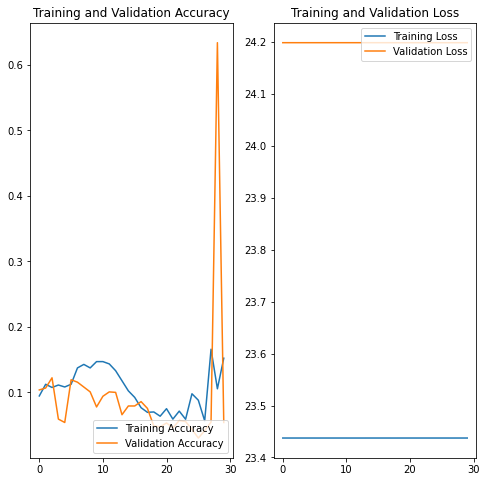

In [43]:
#Visualise the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Final analysis**



*   Accuracy on training data has increased by using Augmentor library


